In [3]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
import graphviz
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

In [4]:
#activate intel optimization
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Load Data

In [5]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
test_transaction_path = "data/test_transaction.csv"
test_identity_path = "data/test_identity.csv"
sample_submission_path = "data/sample_submission.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
# test_transaction = pd.read_csv(test_transaction_path)
# test_identity = pd.read_csv(test_identity_path)
# sample_submission = pd.read_csv(sample_submission_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
# test_df = pd.merge(test_identity, test_transaction, on="TransactionID", how='right')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]

train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]
# test_df_row = test_df.shape[0]
# test_df_col = test_df.shape[1]

print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))
# print('Testing DataFrame: {} rows & {} columns.'.format(test_df_row, test_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 590540 rows & 434 columns.


In [6]:
# release data from those four
del train_transaction
del train_identity
# del test_transaction
# del test_identity

#### Feature Engineering
- Drop rows with more than 90% values missing
- Time
    - Fraud Level (high, mid, low, very low)
    - Minutes to Noon
    - Another column with +- sign
- Transaction Amount:
    - Remove outliers (>30000)
    - Add cent features
- Email Domain:
    - Filter out some very high fraudulent emails
    - Clean some emails
- V
    - Groupby missingness
    - Groupby correlation
    - Keep the column with the most unique values
- UserID
    - Combine card1_d1_addr1
    - Create several means, stds, count aggregations of several features


#### Drop Null Features

In [7]:
def top_missing_cols(df,n=10,thresh=80):
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [8]:
top_missing_cols(train_df, thresh=90)

There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [9]:
# top_missing_cols(test_df, thresh=90)

In [10]:
# We can see that columns like id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_01,id_07,id_08 
# have more than 99 percent missing values. Its better we drop those features.
train_df = train_df.drop(columns=['id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26','id_27','id_01','id_07','id_08'])

### Time

In [11]:
## Day of week (one hot)
def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

# Hour of day (one hot)
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def addr1_transform(x):
    if x in top_ten_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_ten_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_twenty_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_twenty_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

In [12]:
print(min(train_df['TransactionDT']))
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)

86400


In [13]:
# Fraud Level (high, mid, low, very low)

def fraud_level_time(x):
    very_low = [13,14,15,16]
    low = [12, 17, 22, 0, 1]
    mid = [10, 11, 18, 19, 20, 21, 23, 2, 3]
    high = [4, 5, 6, 7, 8, 9]
    if x in very_low:
        return 'very_low'
    elif x in low:
        return 'low'
    elif x in mid:
        return 'mid'
    else:
        return 'high'

train_df['fraud_level_time'] = train_df['TransactionHour'].apply(fraud_level_time)

In [14]:
# Minutes to Noon
noon = 60 * 60 * 12
train_df['time_to_noon'] = train_df.apply(lambda row: (noon - (row['TransactionDT'] % noon))//60 if (row['TransactionHour'] > 12) else (row['TransactionDT'] % noon)//60, axis=1)
train_df['plus_minus_to_noon'] = train_df['TransactionHour'].apply(lambda x: 'minus' if x < 12 else 'plus')

#### Transaction Amount

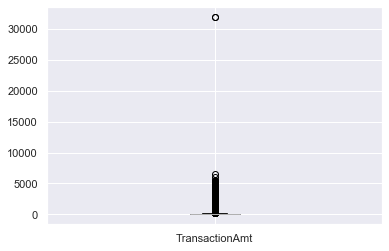

In [15]:
train_df.boxplot(column=['TransactionAmt'])

In [16]:
train_df = train_df[train_df['TransactionAmt'] < 30000]

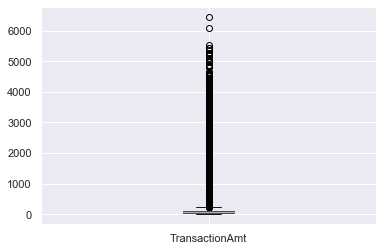

In [17]:
train_df.boxplot(column=['TransactionAmt'])

In [18]:
train_df['cents'] = train_df['TransactionAmt'].apply(lambda x: round(x - math.floor(x), 3))

In [19]:
# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))

#### Email

In [20]:
table_p = pd.pivot_table(train_df, values='TransactionID', index=['P_emaildomain'], columns=['isFraud'], aggfunc='count')
table_p['sum'] = table_p.sum(axis=1)
table_p['0_%'] = table_p[0] / table_p['sum']
table_p['1_%'] = table_p[1] / table_p['sum']
# # # table[[0, 1]]
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_p[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 

In [21]:
#P_emaildomain
safe_p_email = list(table_p[table_p['1_%'].isnull()].index)
sus_p_email = ['aim.com', 'mail.com', 'outlook.es', 'outlook.com']
fraud_p_email = ['protonmail.com']

In [22]:
def email_p(x):
    if x in safe_p_email:
        return 0
    elif x in sus_p_email:
        return 20
    elif x in fraud_p_email:
        return 50
    else:
        return 1

In [23]:
table_r = pd.pivot_table(train_df, values='TransactionID', index=['R_emaildomain'], columns=['isFraud'], aggfunc='count')
table_r['sum'] = table_r.sum(axis=1)
table_r['0_%'] = table_r[0] / table_r['sum']
table_r['1_%'] = table_r[1] / table_r['sum']
# # # table[[0, 1]]
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_r[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 

In [24]:
#R_emaildomain
safe_r_email = list(table_r[table_r['1_%'].isnull()].index)
sus_r_email = ['earthlink.net', 'gmail.com', 'hotmail.com', 'hotmail.es', 'icloud.com'] #5
fraud_r_email = ['mail.com', 'netzero.net', 'outlook.com', 'outlook.es'] #20
death_r_email = ['protonmail.com']  #95

In [25]:
def email_r(x):
    if x in safe_r_email:
        return 0
    elif x in sus_r_email:
        return 5
    elif x in fraud_r_email:
        return 20
    elif x in death_r_email:
        return 95
    else:
        return 1

In [26]:
train_df['email_p_score'] = train_df['P_emaildomain'].apply(email_p)
train_df['email_r_score'] = train_df['R_emaildomain'].apply(email_r)

#### Address

In [27]:
train_df['addr2'].astype(str)

0         87.0
1         87.0
2         87.0
3         87.0
4         87.0
          ... 
590535    87.0
590536    87.0
590537    87.0
590538    87.0
590539    87.0
Name: addr2, Length: 590538, dtype: object

In [28]:
table_a2 = pd.pivot_table(train_df, values='TransactionID', index=['addr2'], columns=['isFraud'], aggfunc='count')
table_a2['sum'] = table_a2.sum(axis=1)
table_a2['0_%'] = table_a2[0] / table_a2['sum']
table_a2['1_%'] = table_a2[1] / table_a2['sum']

In [29]:
# fig, ax = plt.subplots(figsize = (12, 20))
# sns.heatmap(table_a2[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 

In [30]:
table_a2 = table_a2.fillna(0)
a2_df = table_a2[['1_%']]
a2_df['index'] = a2_df.index
addr2_val = list(table_a2.index)
addr2_dict = {}
for i in range(len(addr2_val)):
    addr2_dict[addr2_val[i]] = a2_df.loc[addr2_val[i], '1_%']
addr2_df = train_df[['addr2']].fillna(-1)
train_df['addr2'] = addr2_df['addr2'].copy()
train_df['addr2_score'] = train_df['addr2'].apply(lambda x: -1 if x == -1 else addr2_dict[x])

In [31]:
train_df[['addr2', 'addr2_score']].head(20)

,addr2,addr2_score
0,87.0,0.023972
1,87.0,0.023972
2,87.0,0.023972
3,87.0,0.023972
4,87.0,0.023972
5,87.0,0.023972
6,87.0,0.023972
7,87.0,0.023972
8,87.0,0.023972
9,87.0,0.023972


#### Address 1

In [32]:
table_a1 = pd.pivot_table(train_df, values='TransactionID', index=['addr1'], columns=['isFraud'], aggfunc='count')
table_a1['sum'] = table_a1.sum(axis=1)
table_a1['0_%'] = table_a1[0] / table_a1['sum']
table_a1['1_%'] = table_a1[1] / table_a1['sum']
# fig, ax = plt.subplots(figsize = (12, 100))
# sns.heatmap(table_a1[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 

In [33]:
table_a1 = table_a1.fillna(0)
a1_df = table_a1[['1_%']]
a1_df['index'] = a1_df.index
addr1_val = list(table_a1.index)
addr1_dict = {}
for i in range(len(addr1_val)):
    addr1_dict[addr1_val[i]] = a1_df.loc[addr1_val[i], '1_%']
addr1_df = train_df[['addr1']].fillna(-1)
train_df['addr1'] = addr1_df['addr1'].copy()
train_df['addr1_score'] = train_df['addr1'].apply(lambda x: -1 if x == -1 else addr1_dict[x])

In [34]:
train_df[['addr1', 'addr1_score']].head(2)

,addr1,addr1_score
0,315.0,0.017809
1,325.0,0.025426


In [35]:
#### Device Info

In [36]:
table_di = pd.pivot_table(train_df, values='TransactionID', index=['DeviceInfo'], columns=['isFraud'], aggfunc='count')
table_di['sum'] = table_di.sum(axis=1)
table_di['0_%'] = table_di[0] / table_di['sum']
table_di['1_%'] = table_di[1] / table_di['sum']
# fig, ax = plt.subplots(figsize = (12, 100))
# sns.heatmap(table_di[['0_%', '1_%']], cmap ='RdYlGn', linewidths = 0.30, annot = True) 

In [37]:
table_di = table_di.fillna(0)
di_df = table_di[['1_%']]
di_df['index'] = di_df.index
di_val = list(table_di.index)

In [38]:
di_dict = {}
for i in range(len(di_val)):
    di_dict[di_val[i]] = di_df.loc[di_val[i], '1_%']
di_df = train_df[['DeviceInfo']].fillna(-1)
train_df['DeviceInfo'] = di_df['DeviceInfo'].copy()
train_df['DeviceInfo_score'] = train_df['DeviceInfo'].apply(lambda x: di_dict[x] if x in di_dict.keys() else -1)


In [39]:
train_df[['DeviceInfo', 'DeviceInfo_score']].head(200)

,DeviceInfo,DeviceInfo_score
0,-1,-1.000000
1,-1,-1.000000
2,-1,-1.000000
3,-1,-1.000000
4,SAMSUNG SM-G892A Build/NRD90M,0.000000
...,...,...
195,-1,-1.000000
196,Windows,0.065400
197,iOS Device,0.062683
198,iOS Device,0.062683


#### V

In [40]:
# Groupby missingness
# Groupby correlation
# Keep the column with the most unique values

In [41]:
v_df = train_df.iloc[:, 85:424]
v_miss_df = pd.DataFrame(v_df.isnull().mean())
v_miss_df['col'] = v_miss_df.index
group_by_miss_perc = {}
miss_perc = list(v_miss_df[0])
miss_col = list(v_miss_df['col'])

In [42]:
for i in range(len(miss_perc)):
    if miss_perc[i] not in group_by_miss_perc.keys():
        group_by_miss_perc[miss_perc[i]] = [v_miss_df['col'][i]]
    else:
        group_by_miss_perc[miss_perc[i]].append(v_miss_df['col'][i])

In [43]:
miss_keys = list(group_by_miss_perc.keys())

In [44]:
# group_by_miss_perc

In [45]:
# for i in miss_keys:
#     sub_df = train_df[group_by_miss_perc[i]]
#     corr = sub_df.corr()
#     sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
#     plt.show()

In [46]:
final_col_v = []
for i in range(len(miss_keys)):
    corr = train_df[group_by_miss_perc[miss_keys[i]]].corr()
    group = []
    
    for i in corr.columns:
        sub_group = [i]
        for j in corr.columns:
            if (corr[i][j] > 0.7) and (corr[i][j] < 1):
                sub_group.append(j)
        group.append(sub_group)
    
    for i in group:
        i.sort()
    final_group = []
    
    for i in group:
        if i not in final_group:
            final_group.append(i)
            
    for i in final_group:
        if len(i) != 1:
            temp = {}
            for j in i:
                temp[j] = train_df[j].nunique()
            sorted_temp = sorted(temp.items(), key=lambda item: item[1])
            final_col_v.append(sorted_temp[-1][0])
        else:
            final_col_v.append(i[0])

In [47]:
final_col_v = list(set(final_col_v))

In [48]:
final_col_v.sort()

In [49]:
len(final_col_v)

126

In [50]:
list(train_df.columns)

['TransactionID',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26

### Columns


In [51]:
# list for one-hot
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour', 'fraud_level_time',
               'plus_minus_to_noon', 'ProductCD', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log', 'time_to_noon', 'cents', 'TransactionAmt_log',
         'email_p_score', 'email_r_score', 'addr2_score', 'addr1_score', 'DeviceInfo_score']


num_list = num_list + final_col_v

In [52]:
train_df

,TransactionID,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,...,fraud_level_time,time_to_noon,plus_minus_to_noon,cents,TransactionAmt_log,email_p_score,email_r_score,addr2_score,addr1_score,DeviceInfo_score
0,2987000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,low,0,minus,0.50,4.226834,1,1,0.023972,0.017809,-1.0
1,2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,low,0,minus,0.00,3.367296,1,1,0.023972,0.025426,-1.0
2,2987002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,low,1,minus,0.00,4.077537,20,1,0.023972,0.031955,-1.0
3,2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,low,1,minus,0.00,3.912023,1,1,0.023972,0.031652,-1.0
4,2987004,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,...,low,1,minus,0.00,3.912023,1,1,0.023972,0.032672,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mid,2,plus,0.00,3.891820,1,1,0.023972,0.028598,-1.0
590536,3577536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mid,2,plus,0.50,3.676301,1,1,0.023972,0.026654,-1.0
590537,3577537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mid,2,plus,0.95,3.432373,1,1,0.023972,0.028665,-1.0
590538,3577538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mid,1,plus,0.00,4.762174,1,1,0.023972,0.019177,-1.0


In [53]:
to_ohe = train_df[one_hot_lst]
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(to_ohe)
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())
nums = train_df[num_list].reset_index(drop=True)

In [54]:
X = pd.concat([nums, cates], axis=1)

In [55]:
# release data from temporary features
del ohe
del ohe_features
del cates
del nums

In [56]:
X

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,119,120,121,122,123,124,125,126,127,128
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590533,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
590534,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
590535,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
590536,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [57]:
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]
xxx = X.columns

In [58]:
y.shape

(590538,)

In [59]:
X.shape

(590538, 280)

### Train Test Split

In [61]:
#Raw Ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=59054)

# XGBoost with GridSearch

In [81]:
def XGBGridSearch():
    """
    This function directly takes in the train, test data
    Returns a fitted grid search object
    """
    
    # to ensure those packages are imported
    import xgboost as xgb
    from sklearn.model_selection import GridSearchCV
    import numpy as np
    
    mdl = xgb.XGBClassifier(use_label_encoder=False)
    hyperparameters = {
        'eta':np.linspace(0, 0.2, 4),
        'min_child_weight': [0.5, 1, 1.5],
        'max_depth': [3, 6, 9],
        'subsample': [0.5, 0.75, 1],
        'eval_metric': ['rmse', 'logloss']
    }
    
    grid = GridSearchCV(mdl, hyperparameters, return_train_score = True)
    return grid

Following Cell will require a lot of time to run

In [82]:
# searcher = XGBGridSearch()

In [83]:
# %%time
# searcher.fit(X_train, y_train)

CPU times: total: 10d 15h 35min 38s
Wall time: 22h 4min 43s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use

In [62]:
"""
CPU times: total: 10d 15h 35min 38s
Wall time: 22h 4min 43s
GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None),
             param_grid={'eta': array([0.        , 0.06666667, 0.13333333, 0.2       ]),
                         'eval_metric': ['rmse', 'logloss'],
                         'max_depth': [3, 6, 9],
                         'min_child_weight': [0.5, 1, 1.5],
                         'subsample': [0.5, 0.75, 1]},
             return_train_score=True)
"""

"""
Best parameters: 
{'eta': 0.2,
 'eval_metric': 'rmse',
 'max_depth': 9,
 'min_child_weight': 0.5,
 'subsample': 1}
 """

"\nBest parameters: \n{'eta': 0.2,\n 'eval_metric': 'rmse',\n 'max_depth': 9,\n 'min_child_weight': 0.5,\n 'subsample': 1}\n "

In [62]:
mdl = xgb.XGBClassifier(eta = 0.2,
    eval_metric= 'rmse',
    max_depth= 9,
    min_child_weight= 0.5,
    subsample= 1, 
    use_label_encoder=False)

In [63]:
%%time
mdl.fit(X_train, y_train)

CPU times: total: 14min 12s
Wall time: 1min 18s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.2, eval_metric='rmse', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.200000003, max_delta_step=0, max_depth=9,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.912399 to fit


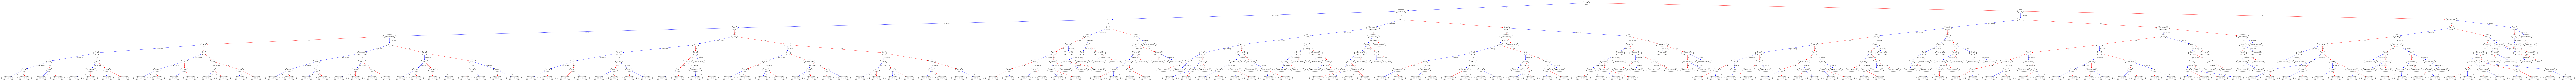

In [69]:
xgb.plot_tree(mdl, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(400, 200)

In [85]:
searcher.best_params_

{'eta': 0.2,
 'eval_metric': 'rmse',
 'max_depth': 9,
 'min_child_weight': 0.5,
 'subsample': 1}

In [64]:
preds = mdl.predict(X_test)
accuracy = accuracy_score(y_test, preds)
y_preds = mdl.predict_proba(X_test)
preds = y_preds[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
auc_score = metrics.auc(fpr, tpr)

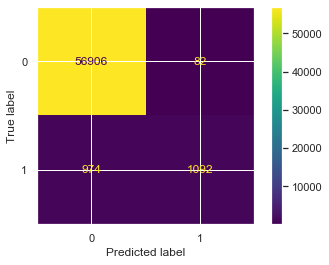

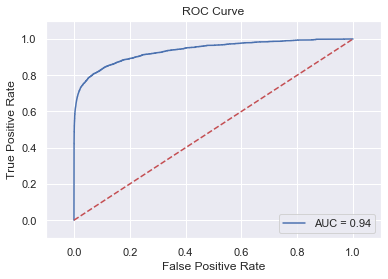

In [66]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [67]:
preds = searcher.predict(X_test)
accuracy = accuracy_score(y_test, preds)
y_preds = searcher.predict_proba(X_test)
preds = y_preds[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
auc_score = metrics.auc(fpr, tpr)

NameError: name 'searcher' is not defined

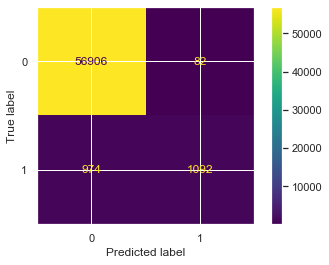

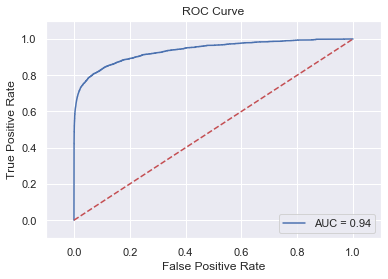

In [68]:
plot_confusion_matrix(mdl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### XGBoost Decision Tree - Raw Ratio

In [69]:
#Raw Ratio
def XGBoost_DT(X_train, X_test, y_train, y_test):
    xgb_cl = xgb.XGBClassifier()
    xgb_cl.fit(X_train, y_train)
    preds = xgb_cl.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = xgb_cl.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [70]:
xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = XGBoost_DT(X_train, X_test, y_train, y_test)

[23:24:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


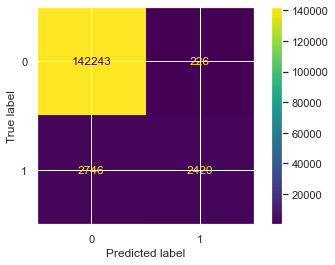

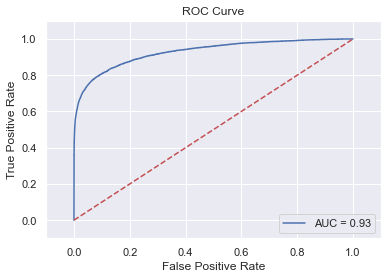

In [106]:
plot_confusion_matrix(xgb_cl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [12]:
### Preparing Test Set
test_df = test_df.drop(columns=['id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26','id_27','id_01','id_07','id_08'])

In [13]:
test_df.shape

(506691, 433)

In [14]:
#min(train_df['TransactionDT']) #86506

In [15]:
#min(test_df['TransactionDT']) #18404013

In [16]:
test_df['TransactionDT'] = test_df['TransactionDT'] - min(train_df['TransactionDT'])
test_df['TransactionDayOfWeek'] = test_df['TransactionDT'].apply(convert_day_of_week)
test_df['TransactionHour'] = test_df['TransactionDT'].apply(convert_hour)
# Transaction Amount (Log)
test_df['TransactionAmt_log'] = test_df['TransactionAmt'].apply(lambda x: np.log(x))
#addr1, addr2
top_ten_addr1 = list(test_df['addr1'].value_counts().index)[:10] #top ten regions
top_ten_addr2 = list(test_df['addr2'].value_counts().index)[:10] #top ten countries
test_df['addr1_new'] = test_df['addr1'].apply(addr1_transform)
test_df['addr2_new'] = test_df['addr2'].apply(addr2_transform)
#Email_Domain
top_twenty_email_p = list(test_df['P_emaildomain'].value_counts().index)[:20] #top ten regions
top_twenty_email_r = list(test_df['R_emaildomain'].value_counts().index)[:20] #top ten countries
test_df['P_emaildomain'].value_counts()
test_df['P_emaildomain_new'] = test_df['P_emaildomain'].apply(email_p_transform)
test_df['R_emaildomain_new'] = test_df['R_emaildomain'].apply(email_r_transform)

In [17]:
test_df.columns = list(train_df.drop(columns=['isFraud']).columns)

In [18]:
ohe_features = ohe.transform(test_df[one_hot_lst])
cates = pd.DataFrame(ohe_features.toarray())
v_data = test_df.iloc[:, 94:433].fillna(0).to_numpy()
nums_part = test_df[num_list]
v = pd.DataFrame(v_data)
nums = pd.concat([nums_part, v], axis = 1)
X = pd.concat([nums, cates], axis=1)
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]
preds = xgb_cl.predict(X)
test_df['isFraud'] = pd.Series(preds)
submission = test_df[['TransactionID', 'isFraud']]
submission.to_csv("submission.csv", index=False)

In [19]:
submission

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0
